In [22]:
#load the synthetic time series
data_path="/home/roseyu/Data/TensorRNN/"
import numpy, pickle
with open(data_path+"lorenz.pkl",'rb') as f:
    data = pickle.load(f)

def norm_row(eg_array):
    normed = (eg_array - eg_array.mean(axis=0)) / eg_array.std(axis=0)
    return normed
data = norm_row(data)
data = data.T
#print "data shape", data.shape
torch.save(data, open('lorenz.pt', 'wb'))

In [10]:
import math
import numpy as np
import torch
T = 20
L = 1000
N = 100
np.random.seed(2)
x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64') # num_var, num_time
print "data shape", data.shape
# torch.save(data, open('traindata.pt', 'wb'))

data shape (100, 1000)


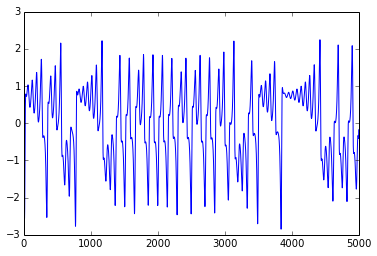

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(data[1,:])

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 1).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 1).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]
        outputs = torch.stack(outputs, 1).squeeze(2) # concatenation
        return outputs



if __name__ == '__main__':
    # set ramdom seed to 0
    np.random.seed(0)
    torch.manual_seed(0)
    # load data and make training set
    data = torch.load('lorenz.pt')
    
    input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
    target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
    # build the model
    seq = Sequence()
    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr= 0.01)
    #begin to train
    for i in range(10):
        print('STEP: ', i)
        def closure(): # closure allow recompute model, for L-BFGS
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.data.numpy()[0])
            loss.backward()
            return loss
        optimizer.step(closure)
        # begin to predict
        future = 1000 #forecast horizon
        pred = seq(input[:3], future = future)
        y = pred.data.numpy()
        np.save('predict%d.npz'%i, y[:3])
        # draw the result
#         plt.figure(figsize=(30,10))
#         plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30) 
#         plt.xlabel('x', fontsize=20)
#         plt.ylabel('y', fontsize=20)
#         plt.xticks(fontsize=20)
#         plt.yticks(fontsize=20)
#         def draw(yi, color):
#             plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
#             plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
#         draw(y[0], 'r')
#         draw(y[1], 'g')
#         draw(y[2], 'b')
        
#         plt.savefig('predict%d.pdf'%i)
#         plt.close()


STEP:  0
loss: 1.65198962437
loss: 1.64854887899
loss: 1.11904742715
loss: 0.396345587321
loss: 0.394991889422
loss: 0.392709948972
loss: 0.389798837152
loss: 0.386192515102
loss: 0.38184210475
loss: 0.376731117767
loss: 0.370896268006
loss: 0.364442999242
loss: 0.357542346051
loss: 0.350402292608
loss: 0.343224507172
loss: 0.336169017742
loss: 0.329341085807
loss: 0.322797254186
loss: 0.316559362073
loss: 0.31062799364
STEP:  1
loss: 0.304992205507
loss: 0.299635604894
loss: 0.294539825894
loss: 0.289686390814
loss: 0.285057638243
loss: 0.280637134082
loss: 0.276409805456
loss: 0.272361931862
loss: 0.26848106745
loss: 0.264755934432
loss: 0.261176308772
loss: 0.257732908873
loss: 0.254417292314
loss: 0.251221762558
loss: 0.248139285975
loss: 0.245163418676
loss: 0.242288242322
loss: 0.239508307923
loss: 0.236818586678
loss: 0.234214426926
STEP:  2
loss: 0.231691516413
loss: 0.229245849153
loss: 0.22687369625


(3, 5999)


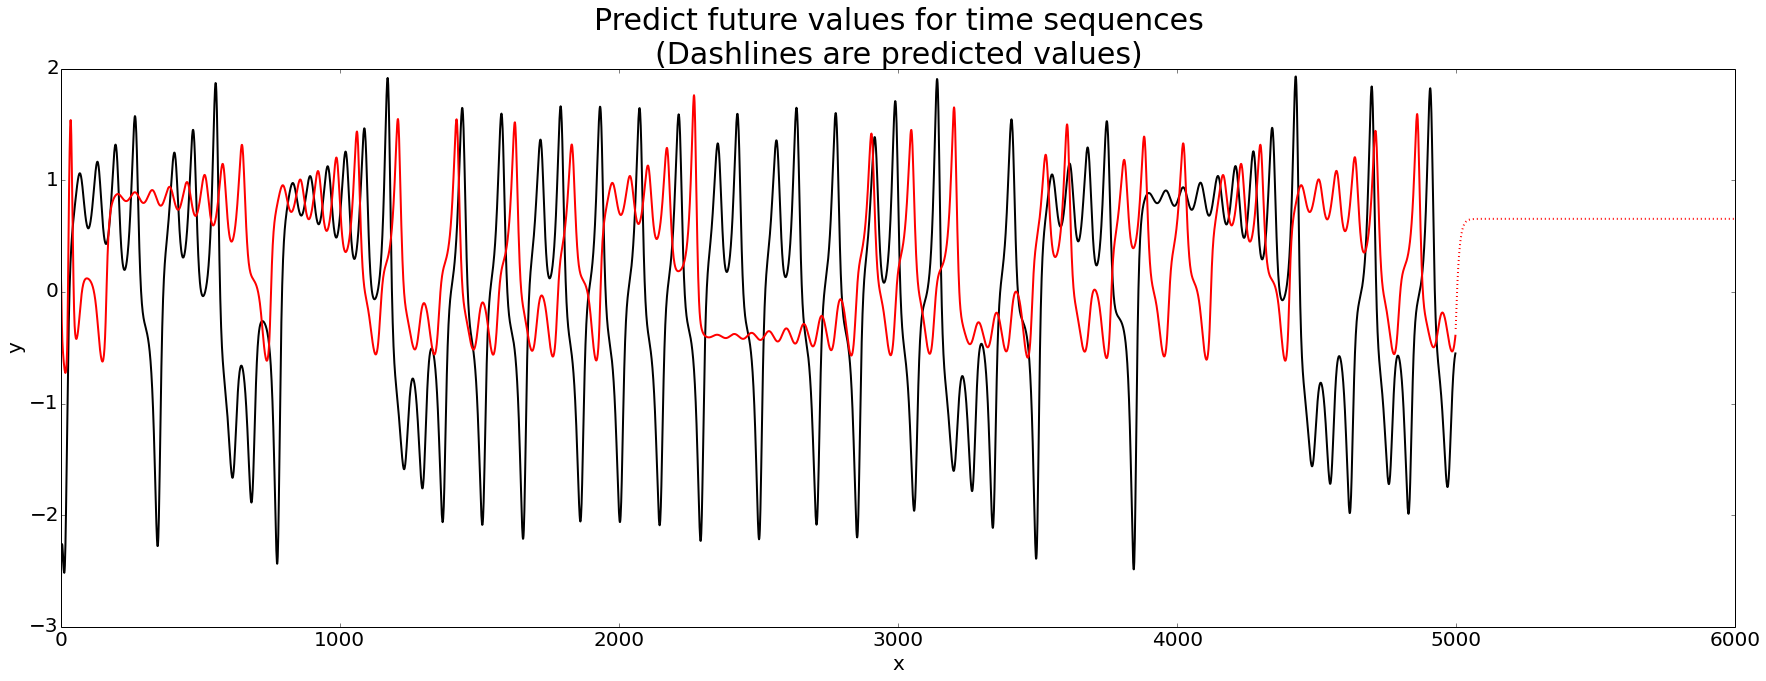

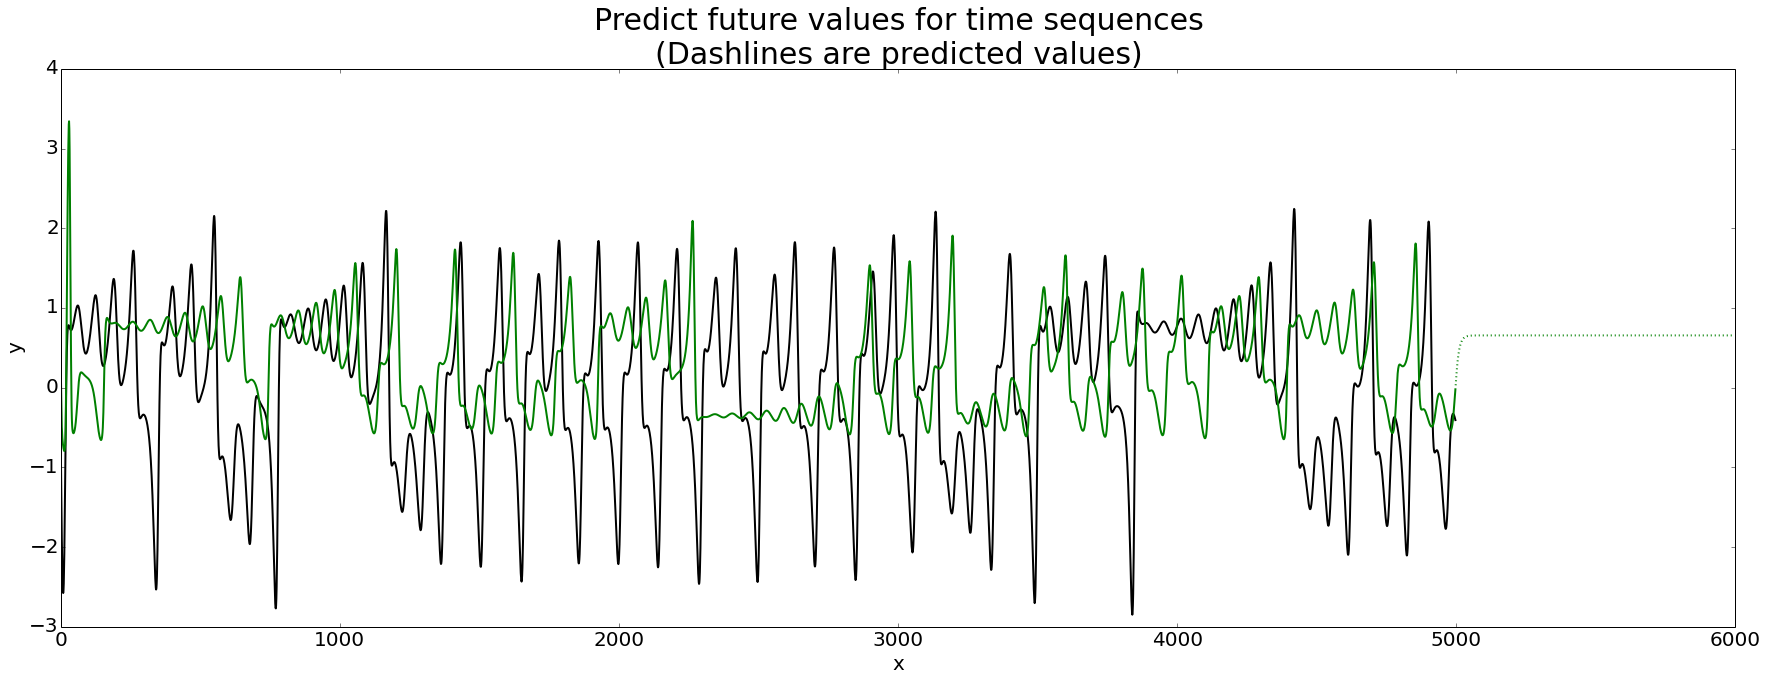

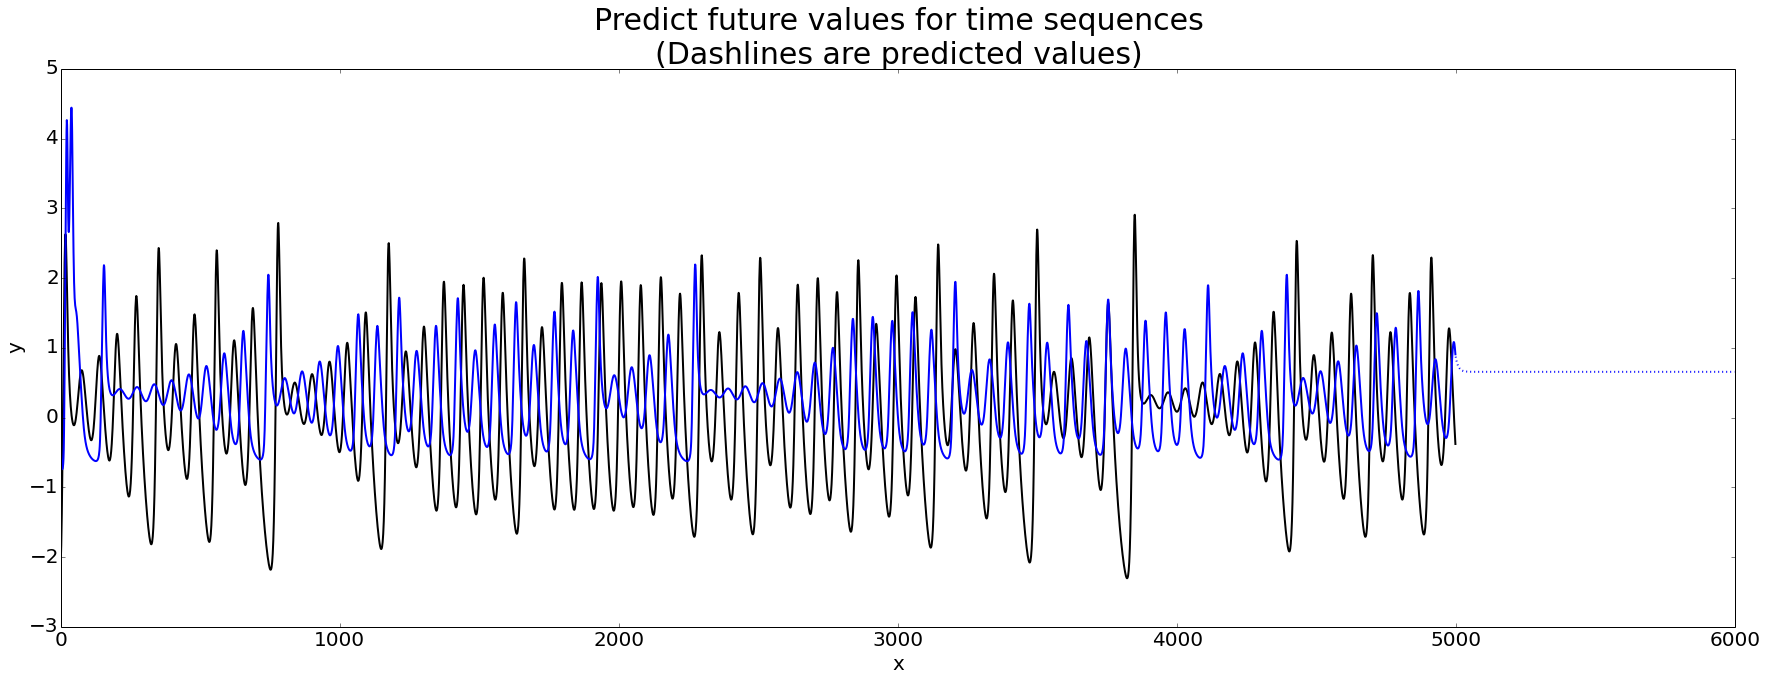

In [38]:
import numpy as np
%matplotlib inline
for i in range(1):
    y = np.load('predict%d.npz.npy'%i)
    print(y.shape)
    future=1000
    def draw(yi, y0, color):
        sz = 4999
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30) 
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(np.arange(sz), y0, 'k', linewidth = 2.0)
        plt.plot(np.arange(sz), yi[:sz], color, linewidth = 2.0)
        plt.plot(np.arange(sz, sz + future), yi[sz:], color + ':', linewidth = 2.0)
    draw(y[0],data[0,:-1], 'r')
    draw(y[1],data[1,:-1],'g')
    draw(y[2],data[2,:-1], 'b')

